In [1]:
from __future__ import division, print_function

# Std lib
import sys
path = "/Users/adrian/projects/biff/build/lib.macosx-10.5-x86_64-2.7/"
if path not in sys.path:
    sys.path.append(path)

path = "/Users/adrian/projects/ophiuchus/"
if path not in sys.path:
    sys.path.append(path)

# Third-party
import astropy.units as u
from astropy.constants import G as _G
import h5py
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
from gary.units import galactic
import gary.potential as gp

import biff
G = _G.decompose(galactic).value

In [7]:
def _isochrone_density(x, y, z, M, r_s):
    """
    .. warning::

        THIS IS AN INTERNAL FUNCTION -- USE ``plummer_density()`` INSTEAD.

    """
    r2 = x*x + y*y + z*z
    a = np.sqrt(r_s**2 + r2)
    return M*(3*(r_s + a)*a**2 - r2*(r_s+3*a))/(4*np.pi*(r_s+a)**3*a**3)

def isochrone_density(xyz, M, r_s):
    """
    Compute the density from a Plummer sphere.

    Parameters
    ----------
    """
    x,y,z = np.atleast_2d(xyz).T
    return _isochrone_density(x,y,z,M,r_s)

_density = _isochrone_density

In [8]:
true_M = 1/G
true_r_s = 1.

x = np.logspace(-2,1,512)
xyz = np.zeros((len(x),3))
xyz[:,0] = x
true_dens = isochrone_density(xyz, true_M, true_r_s)
true_pot = gp.IsochronePotential(m=true_M, b=true_r_s, units=galactic).value(xyz)
true_grad = gp.IsochronePotential(m=true_M, b=true_r_s, units=galactic).gradient(xyz)

In [9]:
nmax = 16
lmax = 0

Snlm = np.zeros((nmax+1,lmax+1,lmax+1))
Serr = np.zeros((nmax+1,lmax+1,lmax+1))
Tnlm = np.zeros((nmax+1,lmax+1,lmax+1))
Terr = np.zeros((nmax+1,lmax+1,lmax+1))

nlms = []
for n in range(nmax+1):
    for l in range(lmax+1):
        for m in range(l+1):
            nlms.append([n,l,m])
       
for nlm in nlms:
    n,l,m = nlm
    print(n,l,m)
    (S,S_err),(T,T_err) = biff.compute_coeffs(_density, nlm=nlm, 
                                              M=true_M, r_s=true_r_s, args=(true_M,true_r_s),
                                              epsrel=1E-9)
    Snlm[n,l,m] = S
    Serr[n,l,m] = S_err
    Tnlm[n,l,m] = T
    Terr[n,l,m] = T_err
        
# OR: load from file..
# with h5py.File("/Users/adrian/projects/ophiuchus/data/Anlm_plummer.h5") as f:
#     nmax = f['nlm'].attrs['nmax']
#     lmax = f['nlm'].attrs['lmax']
#     nlm = np.array(f['nlm'])
#     _Anlm = np.array(f['Anlm'])
#     Anlm_err = np.array(f['Anlm_err'])
    
#     ix = np.abs(_Anlm) > np.abs(Anlm_err)
#     nlm = nlm[ix]
#     _Anlm = _Anlm[ix]

# Anlm = np.zeros((nmax+1, lmax+1, lmax+1))
# for (n,l,m),A in zip(nlm, _Anlm):
#     Anlm[n,l,m] = A

0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0


(1e-06, 1)

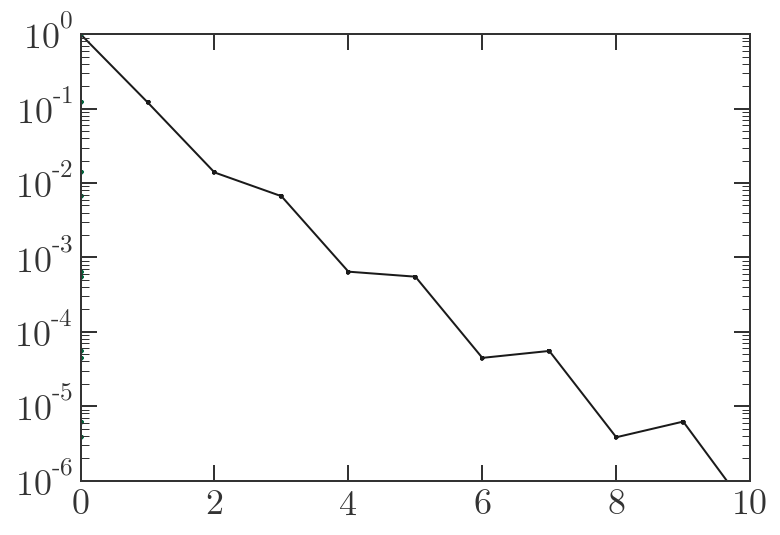

In [14]:
pl.semilogy(np.array(nlms), np.abs(Snlm.flat/Snlm[0,0,0]))
pl.xlim(0,10)
pl.ylim(1E-6, 1)

In [11]:
bfe_dens = biff.density(xyz, true_M, true_r_s, Snlm, Tnlm, nmax, lmax)
bfe_pot = biff.potential(xyz, G, true_M, true_r_s, Snlm, Tnlm, nmax, lmax)
bfe_grad = biff.gradient(xyz, G, true_M, true_r_s, Snlm, Tnlm, nmax, lmax)

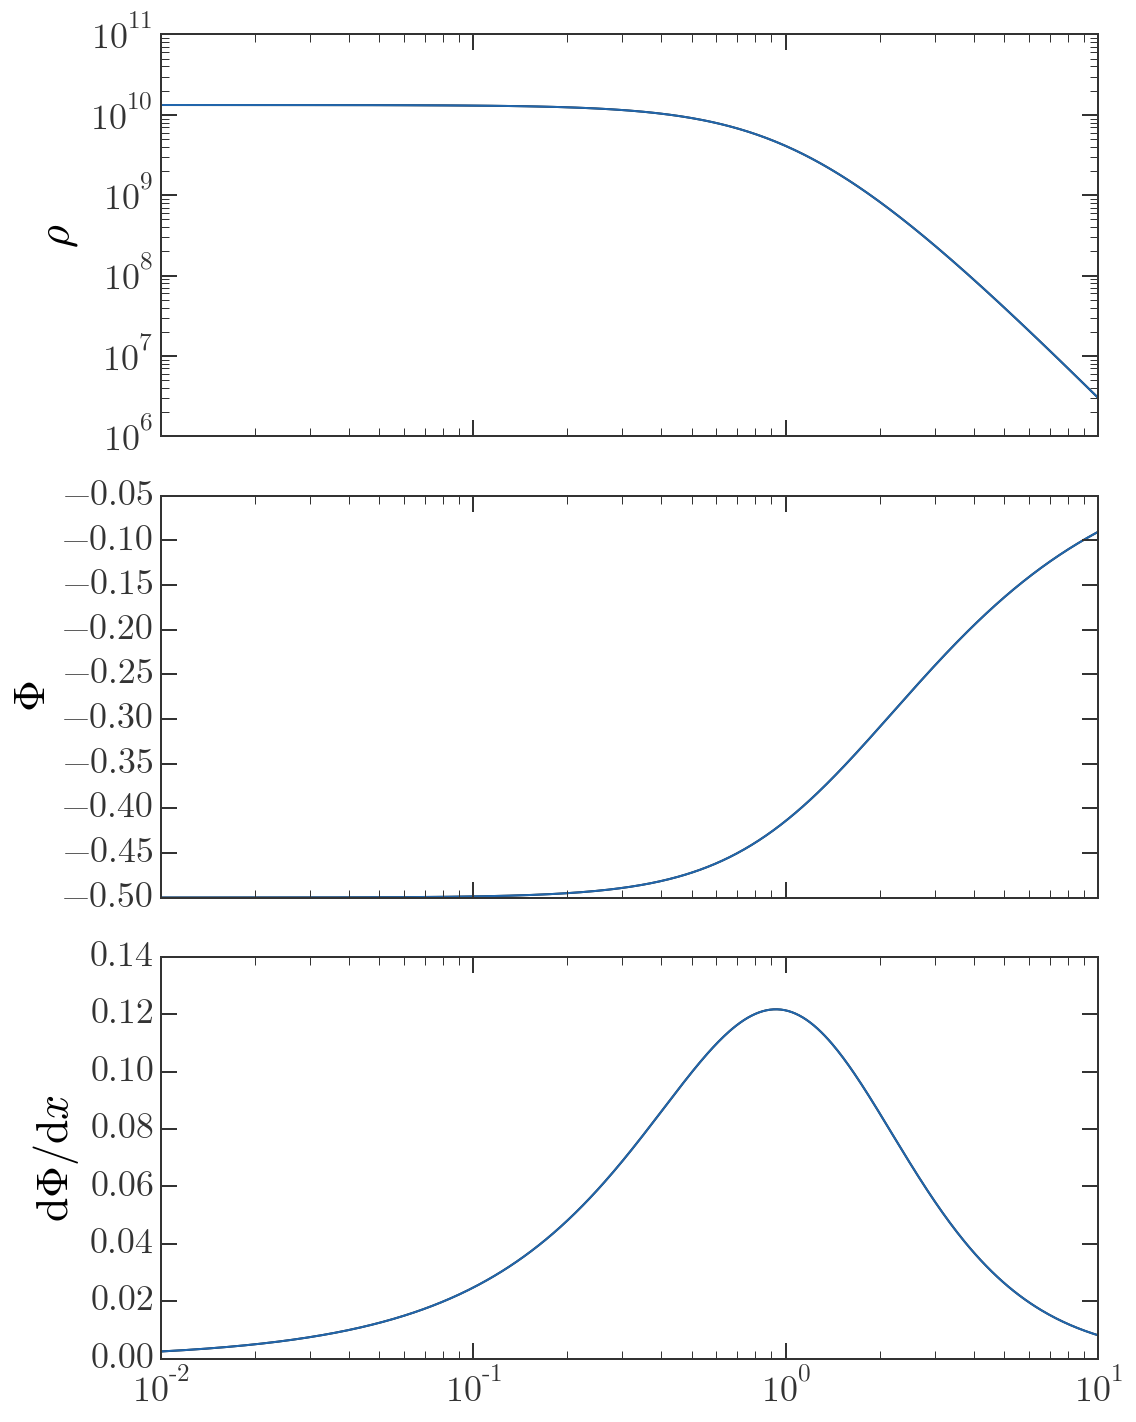

In [12]:
fig,axes = pl.subplots(3, 1, figsize=(8,10), sharex=True)

axes[0].set_ylabel(r'$\rho$')
axes[0].loglog(x, true_dens, marker=None)
axes[0].loglog(x, bfe_dens, marker=None)

axes[1].set_ylabel(r'$\Phi$')
axes[1].semilogx(x, true_pot, marker=None)
axes[1].semilogx(x, bfe_pot, marker=None)

axes[2].set_ylabel(r'${\rm d}\Phi/{\rm d}x$')
axes[2].semilogx(x, true_grad[:,0], marker=None)
axes[2].semilogx(x, bfe_grad[:,0], marker=None)

fig.tight_layout()

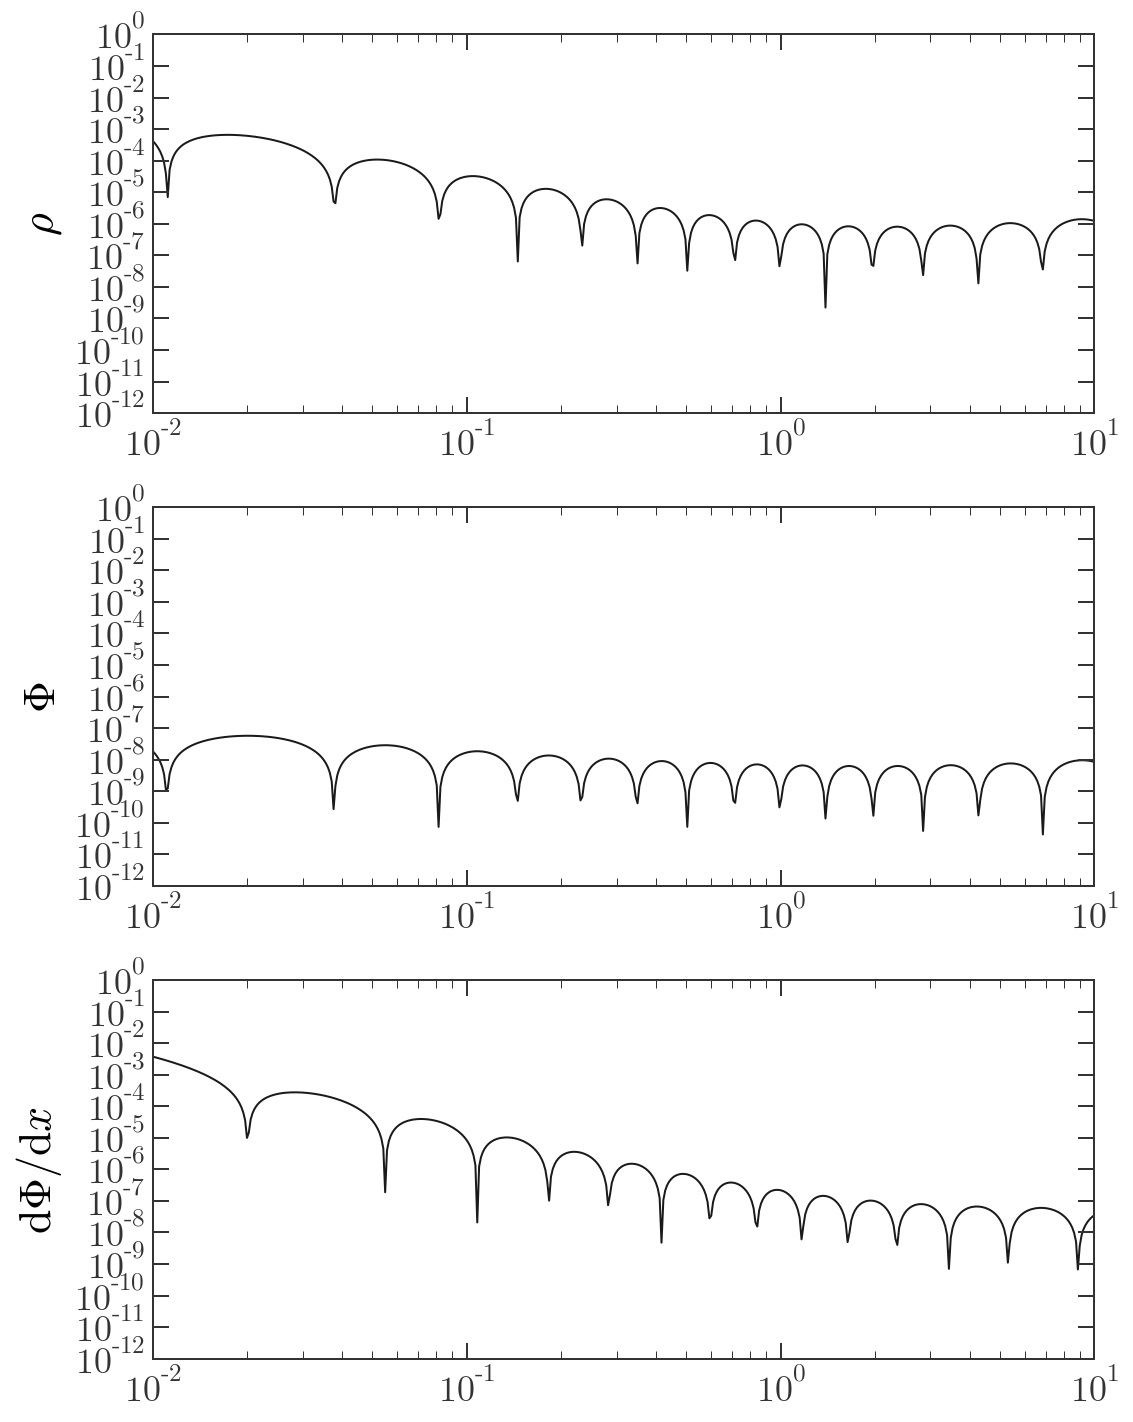

In [13]:
fig,axes = pl.subplots(3, 1, figsize=(8,10), sharey=True)

axes[0].set_ylabel(r'$\rho$')
axes[0].loglog(x, np.abs((true_dens-bfe_dens)/true_dens), marker=None)

axes[1].set_ylabel(r'$\Phi$')
axes[1].loglog(x, np.abs((true_pot-bfe_pot)/true_pot), marker=None)

axes[2].set_ylabel(r'${\rm d}\Phi/{\rm d}x$')
axes[2].loglog(x, np.abs((true_grad[:,0]-bfe_grad[:,0])/true_grad[:,0]), marker=None)

axes[0].set_ylim(1E-12, 1E0)
fig.tight_layout()